In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

# NOTE: WE ASSUME LINEAR RELATIONSHIP WE LINEAR REGRESSION

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.cascade_property_vectorizer import get_vector_from_string

In [ ]:
# Set parameters
file_path = "./../data/no_padding/single/single-data-1731335381437455800.csv"
chunk_size = 1000
test_size = 0.2
random_state = 42

In [5]:
# Initialize lists for collecting data
X_all = []
y_all = []

# Read and process data in chunks
print("Reading and processing data...")
for chunk in pd.read_csv(file_path, chunksize=chunk_size, delimiter=";"):
    X_chunk = np.array([get_vector_from_string(row) 
                       for row in chunk['concatenated_bitstrings']])
    y_chunk = chunk['num_excluded'].values
    X_all.append(X_chunk)
    y_all.append(y_chunk)

Reading and processing data...


<Figure size 2000x1000 with 0 Axes>

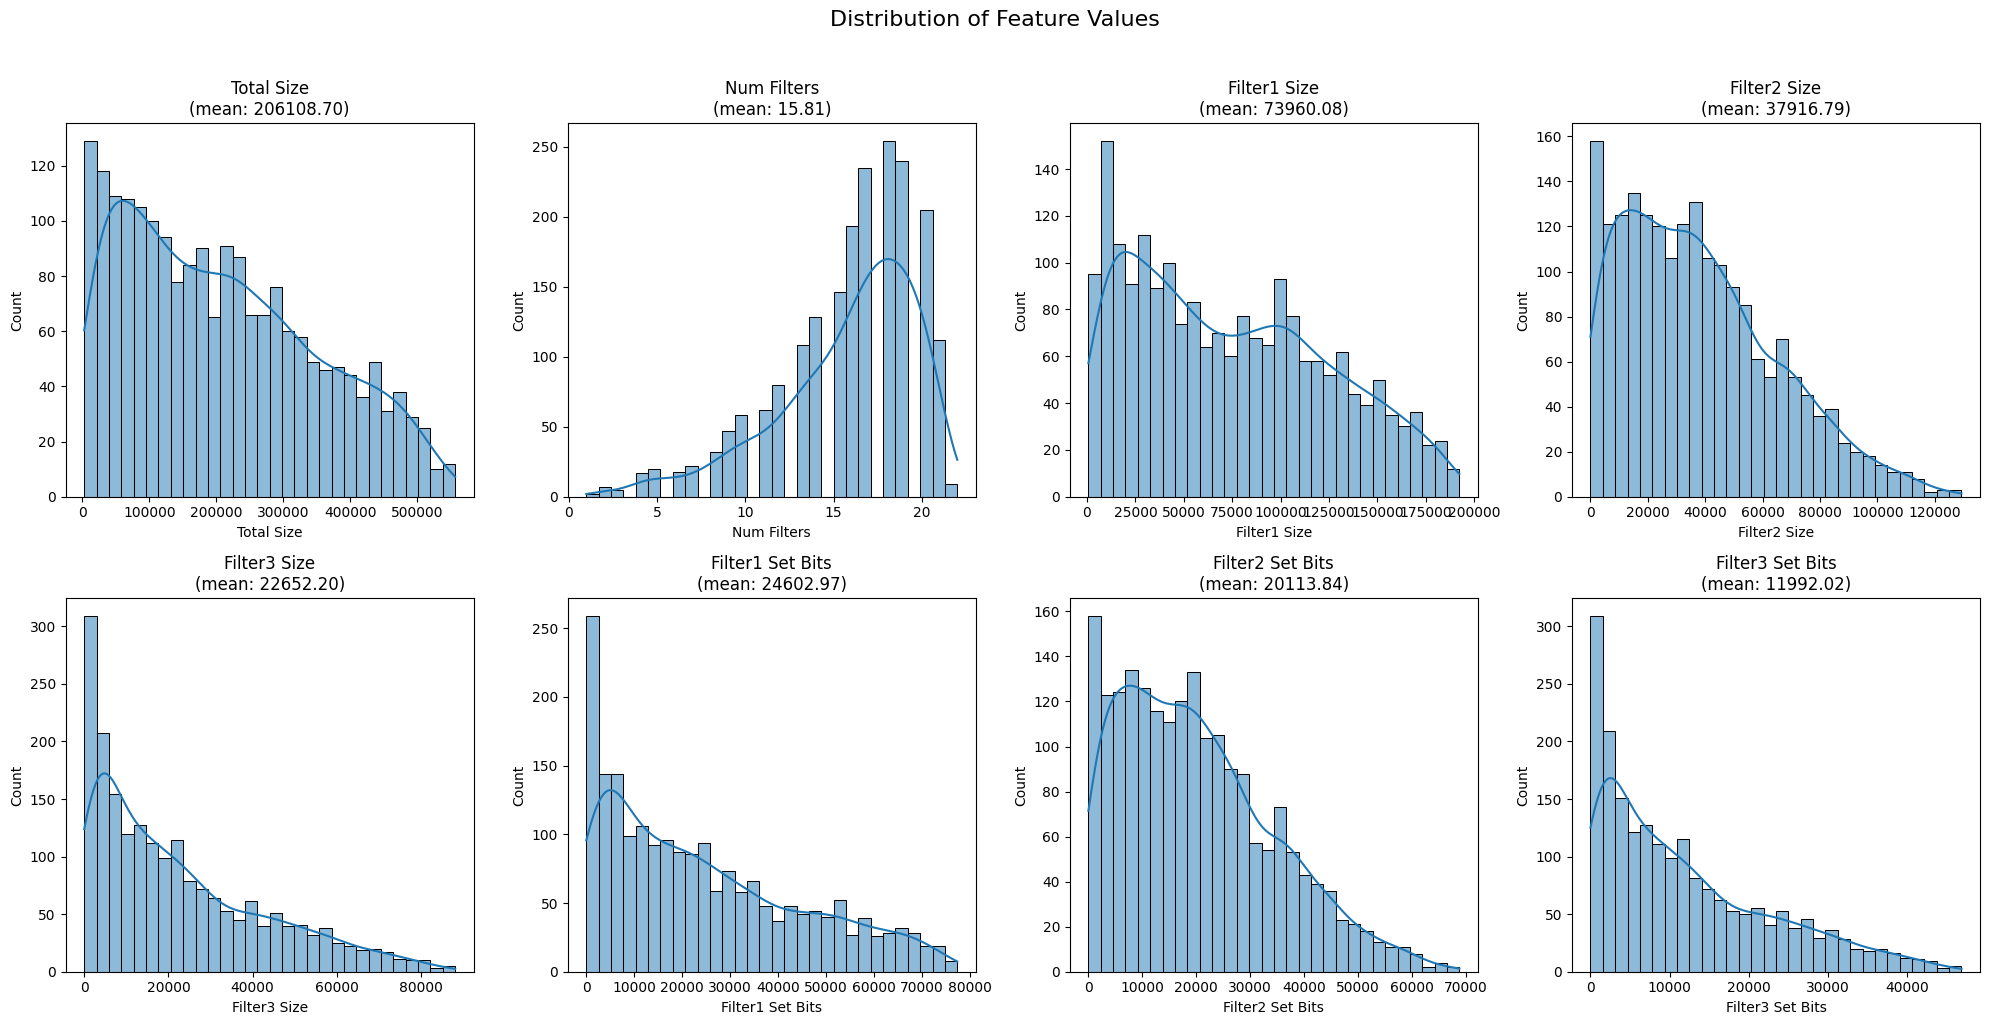

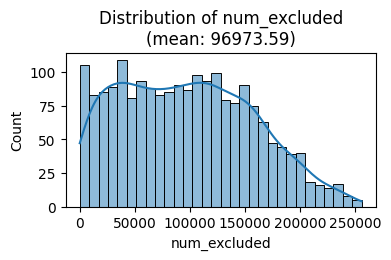

In [6]:
# Combine chunks into one array and create DataFrame
X = np.vstack(X_all)
y = np.concatenate(y_all)

feature_names = [
    'Total Size', 'Num Filters', 'Filter1 Size', 
    'Filter2 Size', 'Filter3 Size', 'Filter1 Set Bits',
    'Filter2 Set Bits', 'Filter3 Set Bits'
]
df = pd.DataFrame(X, columns=feature_names)

# Plot features
plt.figure(figsize=(20, 10))
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Distribution of Feature Values', size=16, y=1.02)

for idx, (feature, ax) in enumerate(zip(feature_names, axes.ravel())):
    sns.histplot(data=df[feature], bins=30, ax=ax, kde=True)
    ax.set_title(f'{feature}\n(mean: {df[feature].mean():.2f})')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 2))
sns.histplot(data=np.concatenate(y_all), bins=30, kde=True)
plt.title(f'Distribution of num_excluded\n(mean: {np.mean(y):.2f})')
plt.xlabel('num_excluded')
plt.ylabel('Count')
plt.show()

In [7]:
# Combine all chunks
X = np.vstack(X_all)
y = np.concatenate(y_all)

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=test_size, random_state=random_state
)

Scaling features...
Splitting data...


In [20]:
# Train linear regression model
print("Training model...")
# model = Lasso(alpha=1.0)
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

Training model...


Ridge()

In [21]:
# Make predictions
y_pred = model.predict(X_test)

In [22]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Model Performance Metrics:
Mean Squared Error: 3761117364.20
R² Score: -0.00


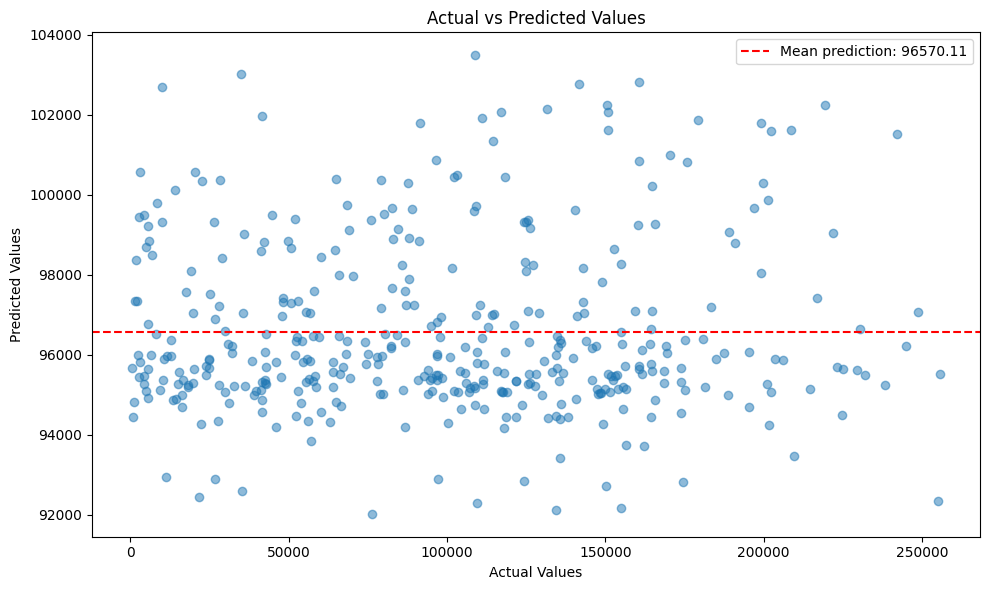

In [23]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.axhline(y=np.mean(y_pred), color='r', linestyle='--', label=f'Mean prediction: {np.mean(y_pred):.2f}')

# Set y-axis limits to the actual range of predictions
y_min, y_max = np.min(y_pred), np.max(y_pred)
plt.ylim(y_min - (y_max - y_min)*0.05, y_max + (y_max - y_min)*0.05)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Feature names
feature_names = [
    'Total Size', 'Num Filters', 'Filter1 Size', 
    'Filter2 Size', 'Filter3 Size', 'Filter1 Set Bits',
    'Filter2 Set Bits', 'Filter3 Set Bits'
]

# Create coefficient analysis
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
})
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

# Print coefficients
print("\nFeature Coefficients (sorted by absolute value):")
for _, row in coefficients.iterrows():
    print(f"{row['Feature']}: {row['Coefficient']:.4f}")


Feature Coefficients (sorted by absolute value):
Filter1 Set Bits: 6109.6552
Filter2 Set Bits: 4365.3892
Filter3 Set Bits: -4133.1463
Filter1 Size: -3705.5742
Filter2 Size: -1287.7782
Filter3 Size: -1244.7290
Num Filters: 1027.8677
Total Size: 265.9794


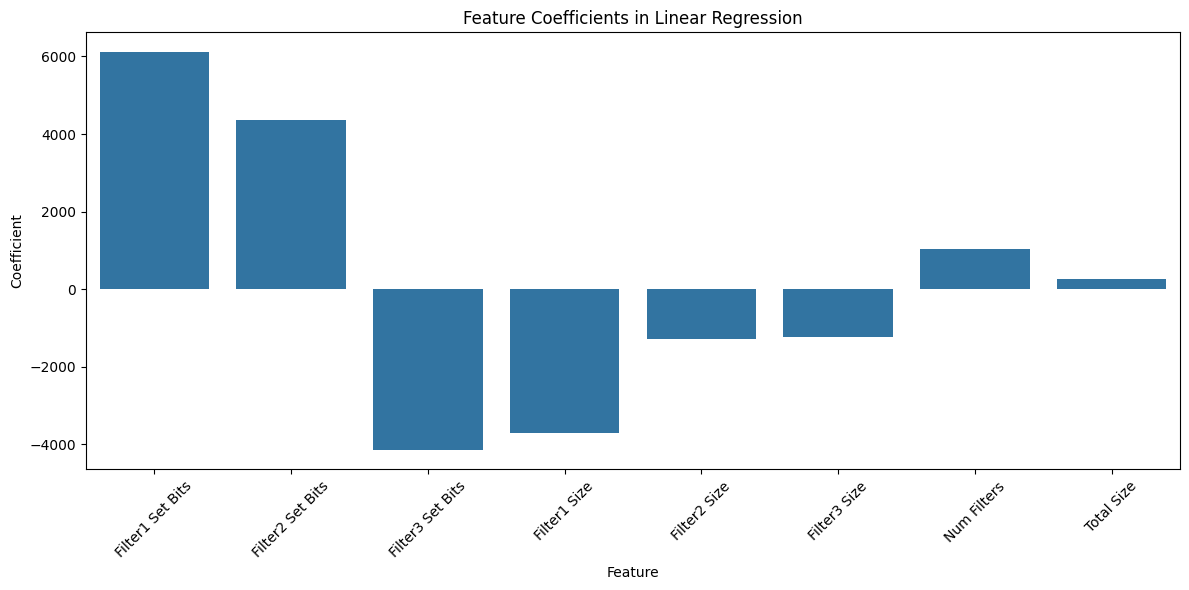

In [25]:
# Plot coefficients
plt.figure(figsize=(12, 6))
sns.barplot(data=coefficients, x='Feature', y='Coefficient')
plt.xticks(rotation=45)
plt.title('Feature Coefficients in Linear Regression')
plt.tight_layout()
plt.show()